In [61]:
from fastcore.all import *
import time

In [62]:
import fastbook
fastbook.setup_book()

In [63]:
from fastbook import *
from fastai.vision.data import PILImage
from fastai.vision.widgets import *

## Step 1: Download Images

fastbook search function

In [64]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

fastdownload download function

In [65]:
download_url

<function fastdownload.core.download_url(url, dest=None, timeout=None, show_progress=True)>

In [111]:
images_motorcycle = search_images_ddg('motorcycle photo')
len(images_motorcycle)

200

In [112]:
images_motorcycle[0]

'https://thumbs.dreamstime.com/b/red-motorcycle-9414812.jpg'

In [113]:
dest1 = 'motorcycle_sample.jpg'
download_url(images_motorcycle[0], dest1, show_progress=False)
print(type(dest1))

<class 'str'>


<class 'PIL.WebPImagePlugin.WebPImageFile'>


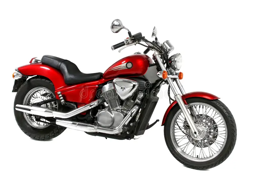

In [114]:
sample_motorcycle_image = Image.open(dest1)
sample_motorcycle_image.thumbnail((256, 256))
print(type(sample_motorcycle_image))
display(sample_motorcycle_image)

<class 'PIL.JpegImagePlugin.JpegImageFile'>


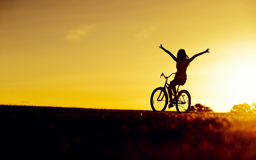

In [134]:
dest2 = 'bicycle_sample.jpg'
download_url(search_images_ddg('bicycle photo')[0], dest2, show_progress=False)
sample_bicycle_image = Image.open(dest2)
sample_bicycle_image.thumbnail((256, 256))
print(type(sample_bicycle_image))
display(sample_bicycle_image)

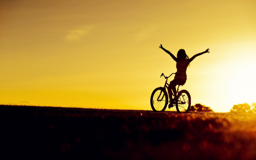

<class 'PIL.Image.Image'>


In [139]:
dest2 = 'bicycle_sample.jpg'
download_url(search_images_ddg('bicycle photo')[0], dest2, show_progress=False)
sample_bicycle_image = PILImage.create(dest2)
sample_bicycle_image = sample_bicycle_image.to_thumb(256, 256)
sample_bicycle_image.show()
print(type(sample_bicycle_image))


download 200 examples of motorcycle and bicycle, each:

In [88]:
searches = 'motorcycle', 'bicycle'
path = Path('motorcycle_or_bicycle')
print(type(path))

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f' {o} photos'))
    resize_images(path/o, max_size=400, dest=path/o)
    

<class 'pathlib.PosixPath'>


## Step 2: Data Organisation and Training

Check for files that did not download properly:

In [89]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

14


Create a Dataloaders object, which contains a training set and validation set. In fastai, we use a Datablock:


Note: in other fastai tutorials, the model trains before DataBlock arrangement and cleaning

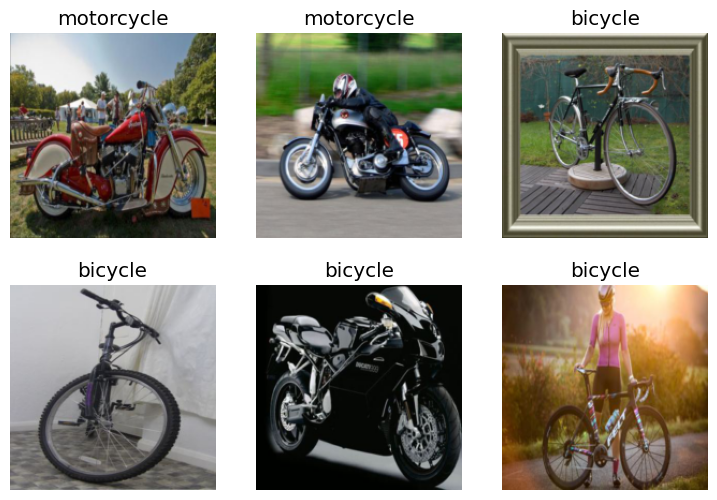

In [95]:
#dlsis a container for training and validation data loaders.
dls = DataBlock(
    
    #inputs are images, outputs are categories:
    blocks=(ImageBlock, CategoryBlock),
    
    #finds all inputs, function returns list of image files in a path
    get_items=get_image_files, 
    
    #split the data into train and valid sets, randomly, 20% for valid
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    
    #gets the name of each category from the name of the parent directory of the file
    get_y=parent_label,
    
    #transforms applied to each item, squish as opposed to cropping or padding
    item_tfms=[Resize(192, method='squish')]

).dataloaders(path)

dls.show_batch(max_n=6)


Begin training using fastai Learner object:

In [97]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/sfturbo/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sfturbo/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.038718,0.626252,0.140940,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.392882,0.143023,0.053691,00:29
1,0.266692,0.067152,0.013423,00:28
2,0.193411,0.061177,0.026846,00:29



Create a confusion matrix

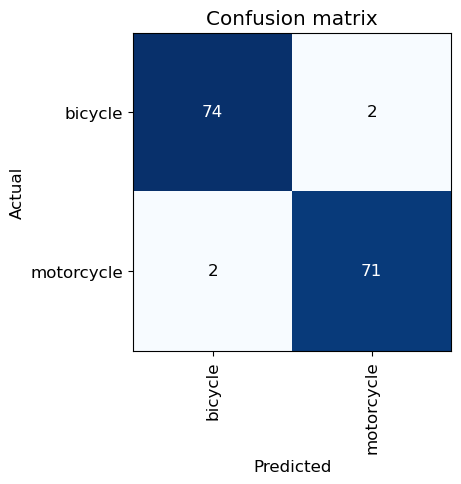

In [98]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Use the Model


Now to use the model on an image outside the train / valid sets,

using the learn.predict method.

First use our motorcycle test image

In [140]:
is_motorcycle_or_bicycle, _, probs = learn.predict(PILImage.create('bicycle_sample.jpg'))
print(type(is_motorcycle_or_bicycle))

index_bicycle = dls.vocab.o2i['bicycle']
print(index_bicycle)
index_motorcycle = dls.vocab.o2i['motorcycle']
print(index_motorcycle)

index_is_motorcycle_or_bicycle = dls.vocab.o2i[is_motorcycle_or_bicycle]
print(index_is_motorcycle_or_bicycle)

print(f'This is a {is_motorcycle_or_bicycle}.')
print(f"Probability it's a {is_motorcycle_or_bicycle} is {probs[index_is_motorcycle_or_bicycle]}")



<class 'fastai.data.transforms.Category'>
This is a bicycle.
0
1
0
Probability it's a bicycle is 0.9999301433563232
